## Functional preference profiles

Now my favorite part, and I think the most unique aspect of our paper.

For each region in the clustering analysis, we're going to determine how well we can classify studies that activated the region, versus those that did not, on the basis of semantic topics that describe the psychological states in each study. 

Using the RegionalClassifier class included in this repo, we can perform this analysis on any given clustering image. I've also included some functons to easily make polar plots to visualize which topics were most strongly associated with any given region

### Classification

In [1]:
%matplotlib inline
from neurosynth.base.dataset import Dataset
dataset = Dataset.load("data/neurosynth_60_0.6.pkl")

In [2]:
from sklearn.naive_bayes import GaussianNB
from classification import RegionalClassifier
from sklearn.metrics import roc_auc_score

We used Gaussian naive Bayes for classificaiton, and extract log odds ratios for each topic for each region to estimate how strongly each psychological state indicated that a given region was active. Note: If you wish to use a different classifier, you must specify a `importance_function` to extract the appropriate values from the classifiers, as these vary for each algorithm. 

In [3]:
# Instantiate a RegionalClassifier for your image and classify
clf = RegionalClassifier(dataset, 'masks/newDMN_4regions.nii.gz', GaussianNB())
clf.classify(scoring=roc_auc_score)

Classifying...
[##########] 100%


We can take a look at various aspects of the classification performance such as the classification performance for each region (in this case ROC area under the curve):

In [4]:
clf.class_score
import pandas as pd
df = pd.DataFrame(clf.class_score)
df.to_csv('AUC.csv')

### Visualization with polar plots

I've included a listing of the topics used in the manuscript, and a set of "nicknames" that I used throughout the manuscript for each topic. This bit of code extracts the nickname (i.e. topic_name) I gave to each topic to help with visualization. You may also use "top_2" to label each topic with the two strongest loading words.

In [5]:
nicknames = pd.read_csv('data/v4-topics-60.txt', delimiter='\t')
nicknames['topic_name'] = nicknames.apply(lambda row: '_'.join([str(row.topic_number)] + row.top_words.split(' ')[0:3]), axis=1)
nicknames = nicknames.sort_values('topic_name')

To recreate the plots from the publication, we simply extract a pandas formatted table of importances that represent how strongly each topic indicated each region would be active in a study (in this case log odds ratios) using `clf.get_formatted_importances`, ensuring to provide the topic nicknames from above. 

Then, we feed this pandas table into plot_clf_polar, which returns a nice polar plot each each prespecified topic.

In [6]:
from plotting import plot_clf_polar

In [7]:
cognitive_topics = ['memory','categorization','switching','inhibition','priming',
                    'social','fear','emotion','learning','reward',  
                    'decision-making','imagery','spatial','attention','WM',
                    'awareness','language','math','semantics','reading']

In [8]:
disease_topics = ['smoking','eating-disorder','depression','schizopherenia','adhd','autism','Alzheimer-Parkinson','ptsd']

In [9]:
selected_topics = ['memory','categorization','switching','inhibition','priming',
                    'social','fear','emotion','learning','reward',  
                    'decision-making','imagery','spatial','attention','WM',
                    'awareness','language','math','semantics','reading','action','pain',
                  'smoking','Alzheimer-Parkinson','eating-disorder','depression','autism','ptsd','adhd','schizopherenia']

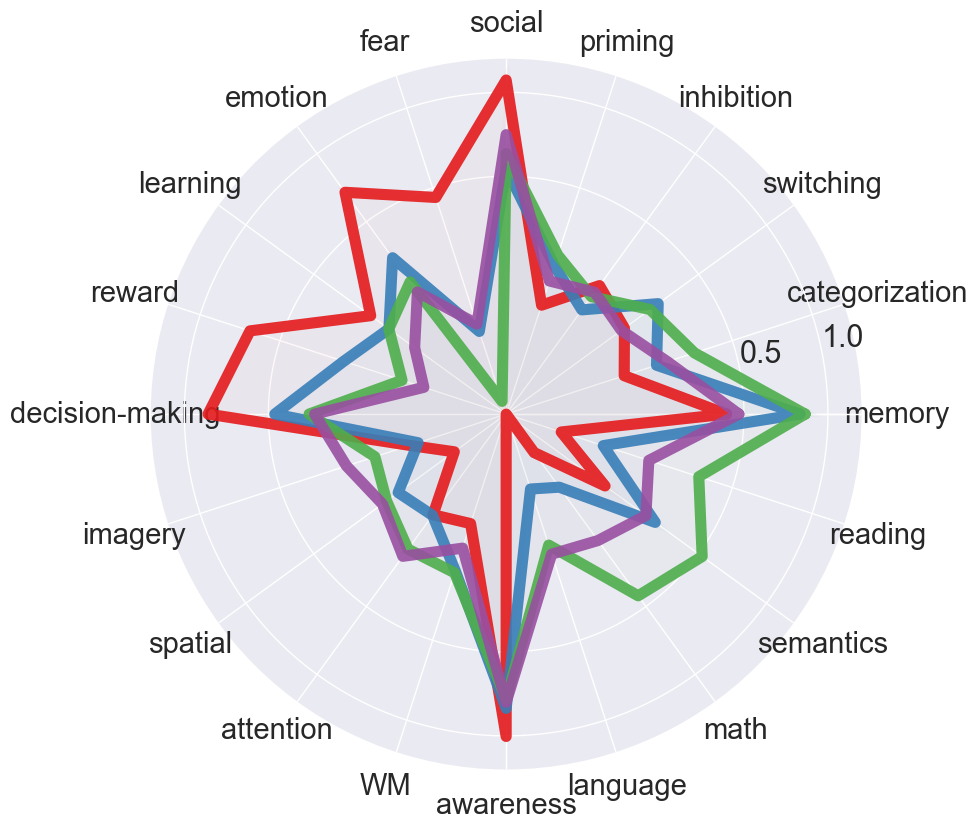

In [10]:
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)
a, b, fig =plot_clf_polar(formated_importances,labels = cognitive_topics, max_val=1.2,label_size=21)

In [13]:
fig.savefig('DMN.svg')

In [13]:
formated_importances = formated_importances.sort_values('importance')
import pandas as pd
df = pd.DataFrame(formated_importances)
df.to_csv("importances_DMN.csv")

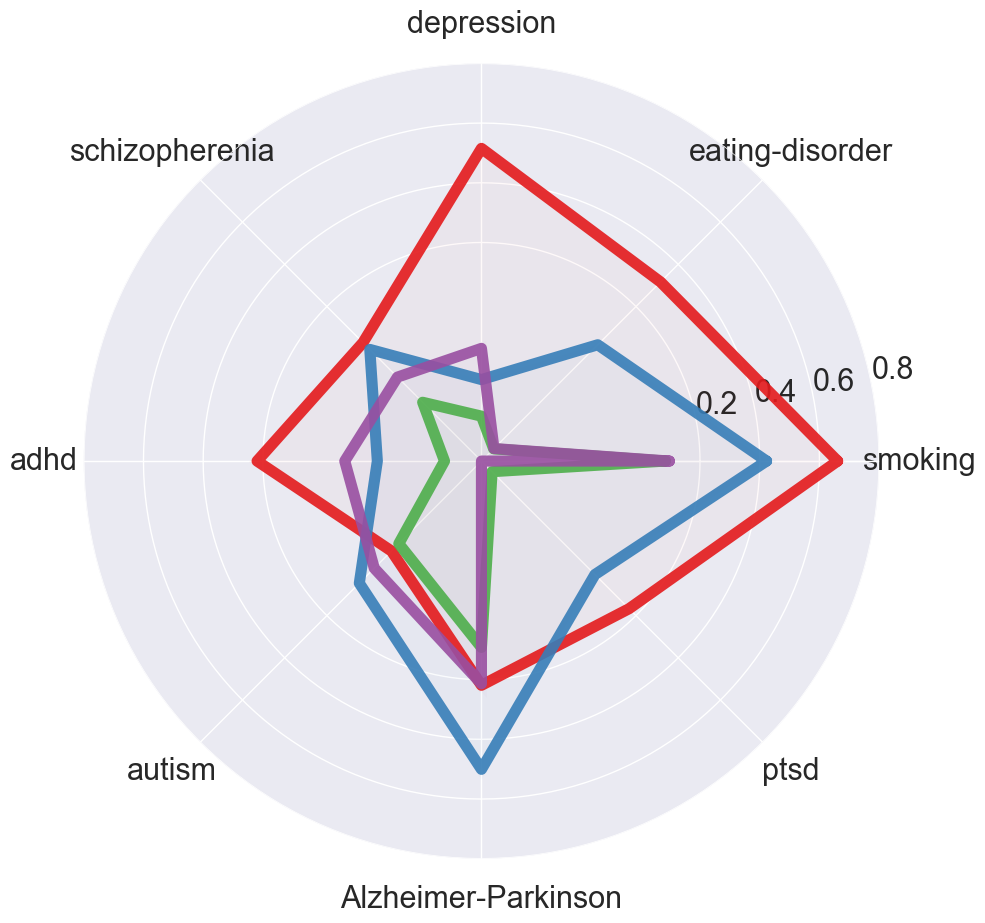

In [14]:
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)
_ = plot_clf_polar(formated_importances, labels = disease_topics, max_val=0.8,label_size=22)

We can also ask plot_clf_polar to choose some topics for us. In this case, we're asking for the 4 topics that load most strongly for each region, and specifiying that these topics are reordered to ensure a nice looking visualization. Under the hood, this function uses hierarchical clustering to reorder the topics. See the docstring of `plot_polar` for many more ways to choose topics and automatically order the features.

In [15]:
%load_ext autoreload
%autoreload 1
%aimport classification

In [16]:
# These are the names of each region given the manuscript
names_70 = ['MPFC','PCC','lTPJ','rTPJ'] #DMN

In [17]:
lor_ci = classification.bootstrap_log_odds(clf, 1000, feature_names=nicknames.nickname, 
                                           region_names = names_70, n_jobs=7)
subset_plot = lor_ci[(lor_ci.topic_name.isin(cognitive_topics))]

df = pd.DataFrame(subset_plot)
df.to_csv('profiles/DMN_cog_ci.csv')

subset_plot = lor_ci[(lor_ci.topic_name.isin(disease_topics))]
df = pd.DataFrame(subset_plot)
df.to_csv('profiles/DMN_dis_ci.csv')

[##########] 100%


In [19]:
from classification import permute_log_odds
lor_z = classification.permute_log_odds(clf, 1000, feature_names=nicknames.nickname, region_names = names_70)

[##########] 100%


In [20]:
cog_ps = lor_z[lor_z.nickname.isin(cognitive_topics)]
from statsmodels.sandbox.stats.multicomp import multipletests

reject, p_corr, a, a1 = multipletests(cog_ps.p, alpha=0.01, method='fdr_tsbky')

cog_ps['p_corr_01'] = p_corr # Adjusted p-value
cog_ps['reject_01'] = (cog_ps.p_corr_01<0.05) & (cog_ps.lor_z > 0) # Was the null hypothesis rejected?

import pandas as pd
df = pd.DataFrame(cog_ps)
df.to_csv("profiles/DMN_cog.csv")


dis_ps = lor_z[lor_z.nickname.isin(disease_topics)]
from statsmodels.sandbox.stats.multicomp import multipletests

reject, p_corr, a, a1 = multipletests(dis_ps.p, alpha=0.01, method='fdr_tsbky')

dis_ps['p_corr_01'] = p_corr # Adjusted p-value
dis_ps['reject_01'] = (dis_ps.p_corr_01<0.05) & (dis_ps.lor_z > 0)
import pandas as pd
df = pd.DataFrame(dis_ps)
df.to_csv("profiles/DMN_dis.csv")

/Users/shaoming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaoming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaoming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

In [37]:
clf = RegionalClassifier(dataset, 'images/MPFC/cluster_labels_k2.nii.gz', GaussianNB())
clf.classify(scoring=roc_auc_score)

Classifying...
[##########] 100%


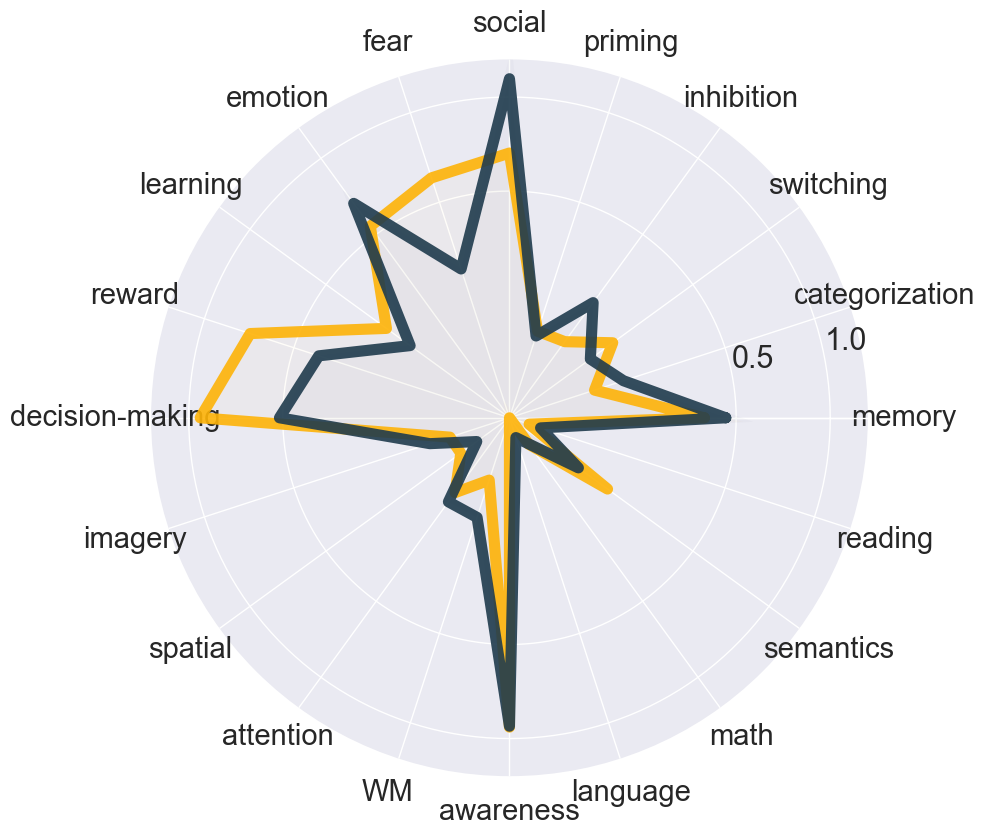

In [38]:
%matplotlib inline
import seaborn as sns
from nilearn import plotting as niplt
from matplotlib.colors import ListedColormap
import numpy as np
colors = ["amber","dark blue grey"]
colors = sns.xkcd_palette(colors)
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)
_ = plot_clf_polar(formated_importances,labels = cognitive_topics,
                   palette = colors, max_val=1.2,label_size=21)

In [24]:
formated_importances = formated_importances.sort_values('importance')
import pandas as pd
df = pd.DataFrame(formated_importances)
df.to_csv("importances_MPFC.csv")

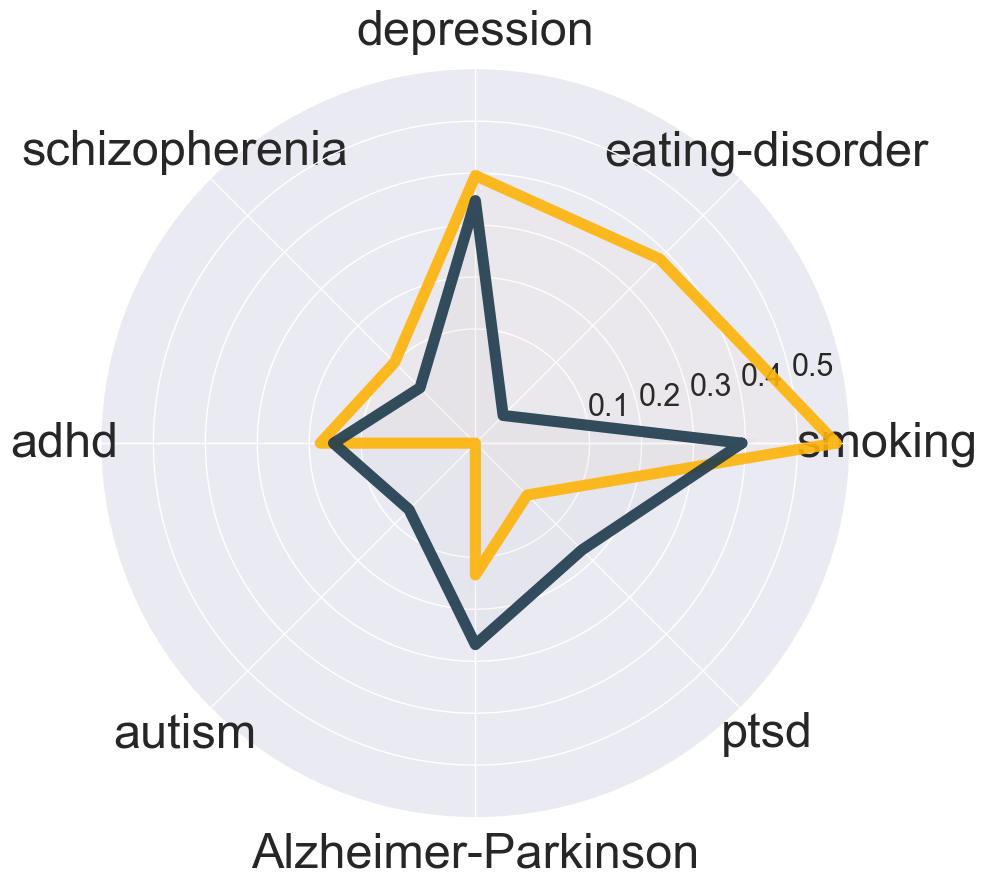

In [39]:
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)
_ = plot_clf_polar(formated_importances, labels = disease_topics, palette = colors,
                   label_size=35,max_val=0.6)

In [26]:
# These are the names of each region given the manuscript
names_70 = ['ventral','dorsal'] #MPFC ['posterior','ventral','dorsal']

In [27]:
lor_ci = classification.bootstrap_log_odds(clf, 1000, feature_names=nicknames.nickname, 
                                           region_names = names_70, n_jobs=7)
subset_plot = lor_ci[(lor_ci.topic_name.isin(cognitive_topics))]
import pandas as pd
df = pd.DataFrame(subset_plot)
df.to_csv('profiles/MPFC_cog_ci.csv')

subset_plot = lor_ci[(lor_ci.topic_name.isin(disease_topics))]
df = pd.DataFrame(subset_plot)
df.to_csv('profiles/MPFC_dis_ci.csv')

[##########] 100%


In [28]:
from classification import permute_log_odds
lor_z = classification.permute_log_odds(clf, 1000, feature_names=nicknames.nickname, region_names = names_70)

[##########] 100%


In [29]:
cog_ps = lor_z[lor_z.nickname.isin(cognitive_topics)]
from statsmodels.sandbox.stats.multicomp import multipletests

reject, p_corr, a, a1 = multipletests(cog_ps.p, alpha=0.01, method='fdr_tsbky')

cog_ps['p_corr_01'] = p_corr # Adjusted p-value
cog_ps['reject_01'] = (cog_ps.p_corr_01<0.05) & (cog_ps.lor_z > 0) # Was the null hypothesis rejected?

import pandas as pd
df = pd.DataFrame(cog_ps)
df.to_csv("profiles/MPFC_cog.csv")


dis_ps = lor_z[lor_z.nickname.isin(disease_topics)]
from statsmodels.sandbox.stats.multicomp import multipletests

reject, p_corr, a, a1 = multipletests(dis_ps.p, alpha=0.01, method='fdr_tsbky')

dis_ps['p_corr_01'] = p_corr # Adjusted p-value
dis_ps['reject_01'] = (dis_ps.p_corr_01<0.05) & (dis_ps.lor_z > 0)
import pandas as pd
df = pd.DataFrame(dis_ps)
df.to_csv("profiles/MPFC_dis.csv")

/Users/shaoming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaoming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaoming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

In [40]:
clf = RegionalClassifier(dataset, 'images/PCC/cluster_labels_k3.nii.gz', GaussianNB())
clf.classify(scoring=roc_auc_score)

Classifying...
[##########] 100%


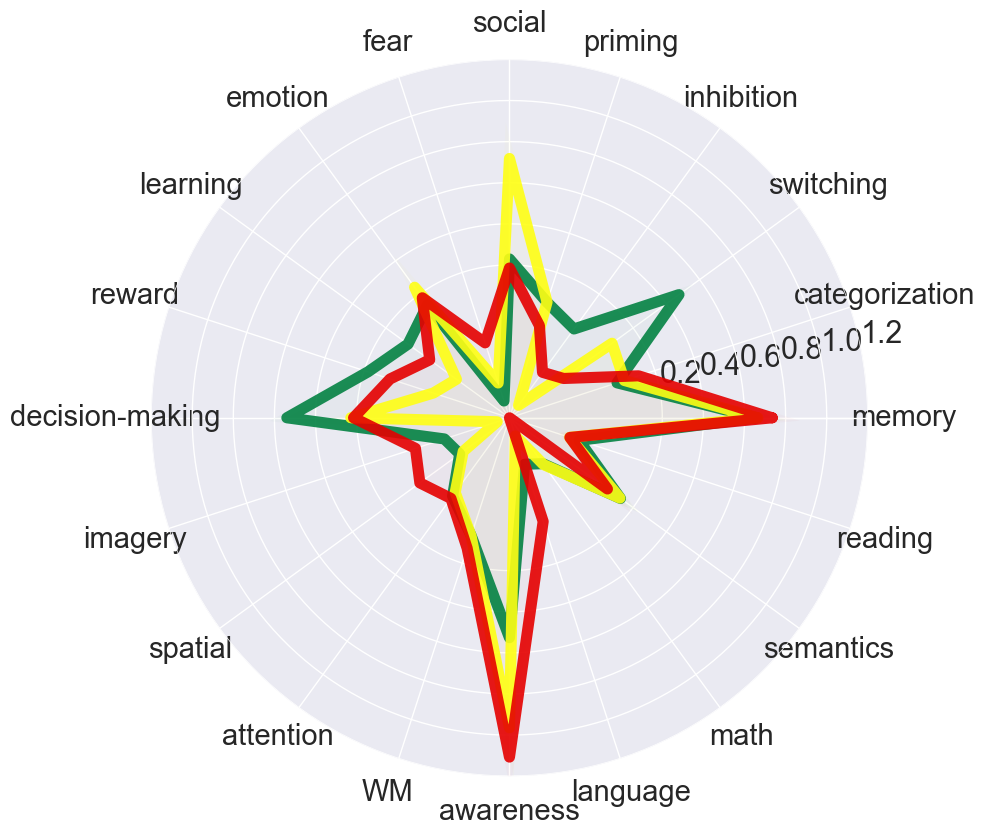

In [41]:
colors = ["jungle green","yellow","red"]
colors = sns.xkcd_palette(colors)
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)
_ = plot_clf_polar(formated_importances,labels = cognitive_topics, palette = colors, 
                   max_val=1.2,label_size=21)

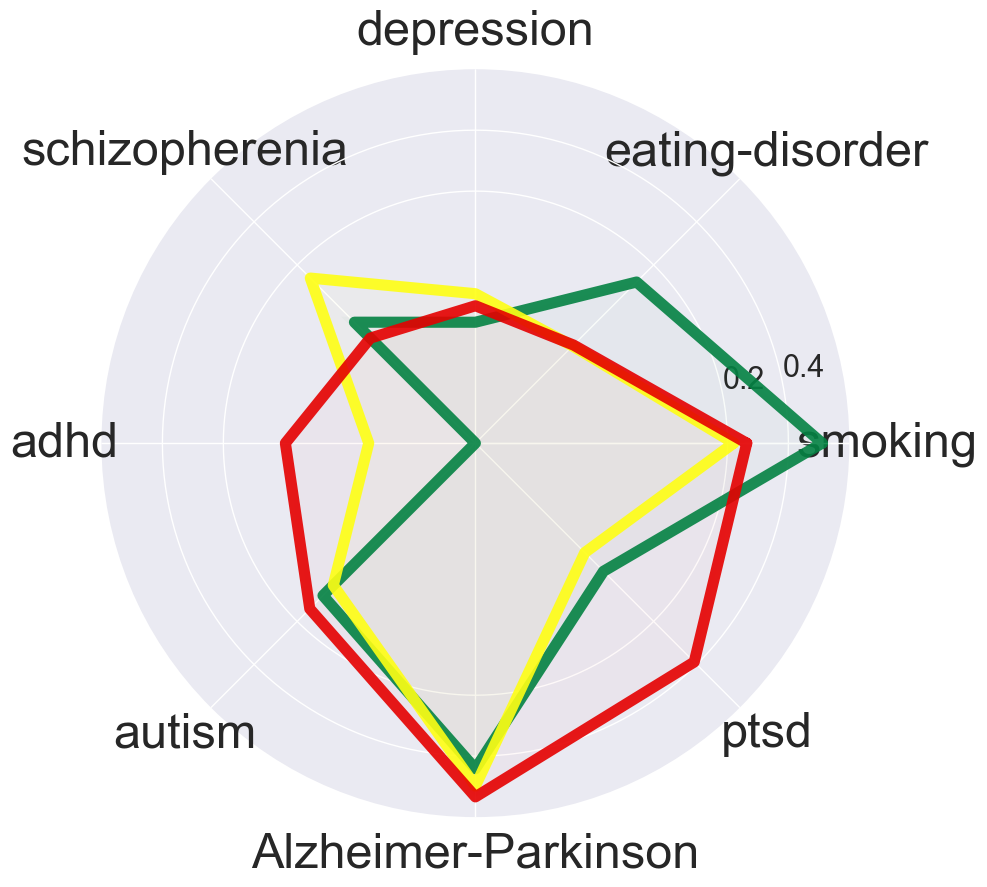

In [42]:
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)
_ = plot_clf_polar(formated_importances, labels = disease_topics, 
                   palette = colors,label_size=35,max_val=0.6
                  )

In [33]:
# These are the names of each region given the manuscript
names_70 = ['dorsal','medial','ventral'] #PCC

In [34]:
lor_ci = classification.bootstrap_log_odds(clf, 1000, feature_names=nicknames.nickname, 
                                           region_names = names_70, n_jobs=7)
subset_plot = lor_ci[(lor_ci.topic_name.isin(cognitive_topics))]
import pandas as pd
df = pd.DataFrame(subset_plot)
df.to_csv('profiles/PCC_cog_ci.csv')

subset_plot = lor_ci[(lor_ci.topic_name.isin(disease_topics))]
df = pd.DataFrame(subset_plot)
df.to_csv('profiles/PCC_dis_ci.csv')

[##########] 100%


In [35]:
from classification import permute_log_odds
lor_z = classification.permute_log_odds(clf, 1000, feature_names=nicknames.nickname, region_names = names_70)

[##########] 100%


In [36]:
cog_ps = lor_z[lor_z.nickname.isin(cognitive_topics)]
from statsmodels.sandbox.stats.multicomp import multipletests

reject, p_corr, a, a1 = multipletests(cog_ps.p, alpha=0.01, method='fdr_tsbky')

cog_ps['p_corr_01'] = p_corr # Adjusted p-value
cog_ps['reject_01'] = (cog_ps.p_corr_01<0.05) & (cog_ps.lor_z > 0) # Was the null hypothesis rejected?

import pandas as pd
df = pd.DataFrame(cog_ps)
df.to_csv("profiles/PCC_cog.csv")


dis_ps = lor_z[lor_z.nickname.isin(disease_topics)]
from statsmodels.sandbox.stats.multicomp import multipletests

reject, p_corr, a, a1 = multipletests(dis_ps.p, alpha=0.01, method='fdr_tsbky')

dis_ps['p_corr_01'] = p_corr # Adjusted p-value
dis_ps['reject_01'] = (dis_ps.p_corr_01<0.05) & (dis_ps.lor_z > 0)
import pandas as pd
df = pd.DataFrame(dis_ps)
df.to_csv("profiles/PCC_dis.csv")

/Users/shaoming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaoming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaoming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

In [43]:
clf = RegionalClassifier(dataset, 'images/lTPJ/cluster_labels_k3.nii.gz', GaussianNB())
clf.classify(scoring=roc_auc_score)

Classifying...
[##########] 100%


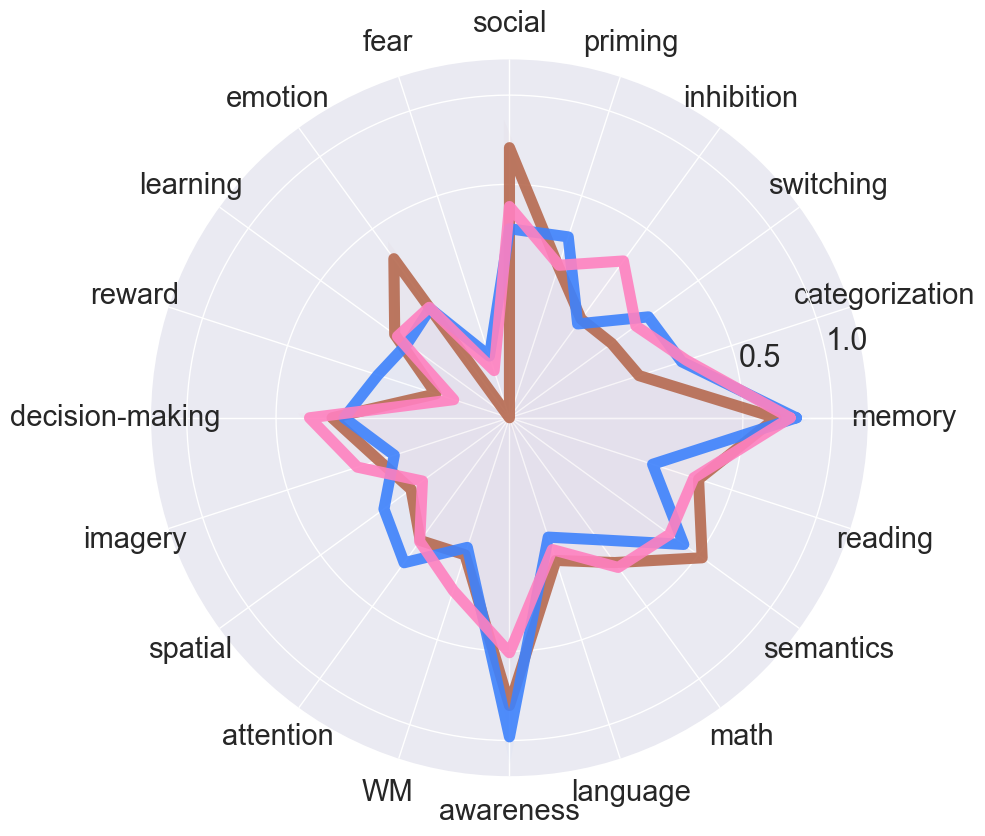

In [45]:
colors = ["clay","dodger blue","pink"]
colors = sns.xkcd_palette(colors)
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)
_ = plot_clf_polar(formated_importances,labels = cognitive_topics, 
                   palette = colors, label_size=21,max_val=1.2
                  )

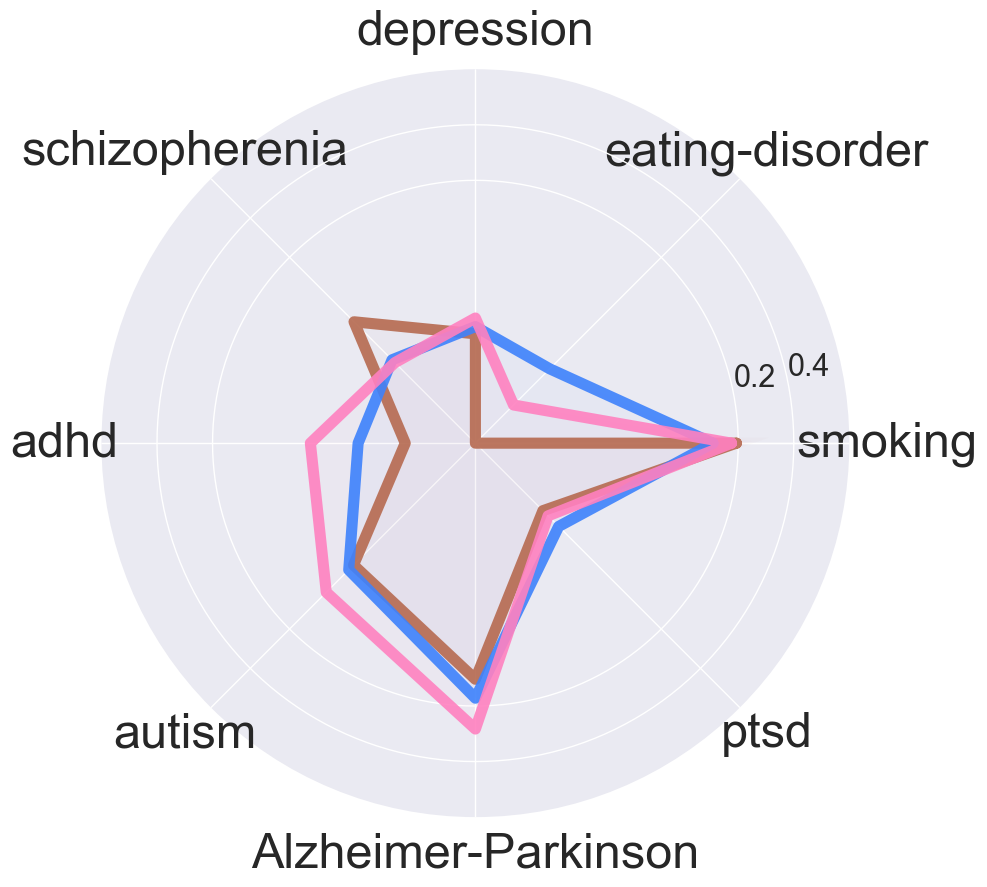

In [46]:
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)
_ = plot_clf_polar(formated_importances, labels = disease_topics, palette = colors,label_size=35,max_val=0.6)

In [40]:
# These are the names of each region given the manuscript
names_70 = ['ventral','posterior','dorsal']#['ventral','dorsal','medial'] #lTPJ

In [41]:
lor_ci = classification.bootstrap_log_odds(clf, 1000, feature_names=nicknames.nickname, 
                                           region_names = names_70, n_jobs=7)
subset_plot = lor_ci[(lor_ci.topic_name.isin(cognitive_topics))]
import pandas as pd
df = pd.DataFrame(subset_plot)
df.to_csv('profiles/lTPJ_cog_ci.csv')

subset_plot = lor_ci[(lor_ci.topic_name.isin(disease_topics))]
df = pd.DataFrame(subset_plot)
df.to_csv('profiles/lTPJ_dis_ci.csv')

[##########] 100%


In [42]:
from classification import permute_log_odds
lor_z = classification.permute_log_odds(clf, 1000, feature_names=nicknames.nickname, region_names = names_70)

[##########] 100%


In [43]:
cog_ps = lor_z[lor_z.nickname.isin(cognitive_topics)]
from statsmodels.sandbox.stats.multicomp import multipletests

reject, p_corr, a, a1 = multipletests(cog_ps.p, alpha=0.01, method='fdr_tsbky')

cog_ps['p_corr_01'] = p_corr # Adjusted p-value
cog_ps['reject_01'] = (cog_ps.p_corr_01<0.05) & (cog_ps.lor_z > 0) # Was the null hypothesis rejected?

import pandas as pd
df = pd.DataFrame(cog_ps)
df.to_csv("profiles/lTPJ_cog.csv")


dis_ps = lor_z[lor_z.nickname.isin(disease_topics)]
from statsmodels.sandbox.stats.multicomp import multipletests

reject, p_corr, a, a1 = multipletests(dis_ps.p, alpha=0.01, method='fdr_tsbky')

dis_ps['p_corr_01'] = p_corr # Adjusted p-value
dis_ps['reject_01'] = (dis_ps.p_corr_01<0.05) & (dis_ps.lor_z > 0)
import pandas as pd
df = pd.DataFrame(dis_ps)
df.to_csv("profiles/lTPJ_dis.csv")

/Users/shaoming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaoming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaoming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

In [47]:
clf = RegionalClassifier(dataset, 'images/rTPJ/cluster_labels_k2.nii.gz', GaussianNB())
clf.classify(scoring=roc_auc_score)

Classifying...
[##########] 100%


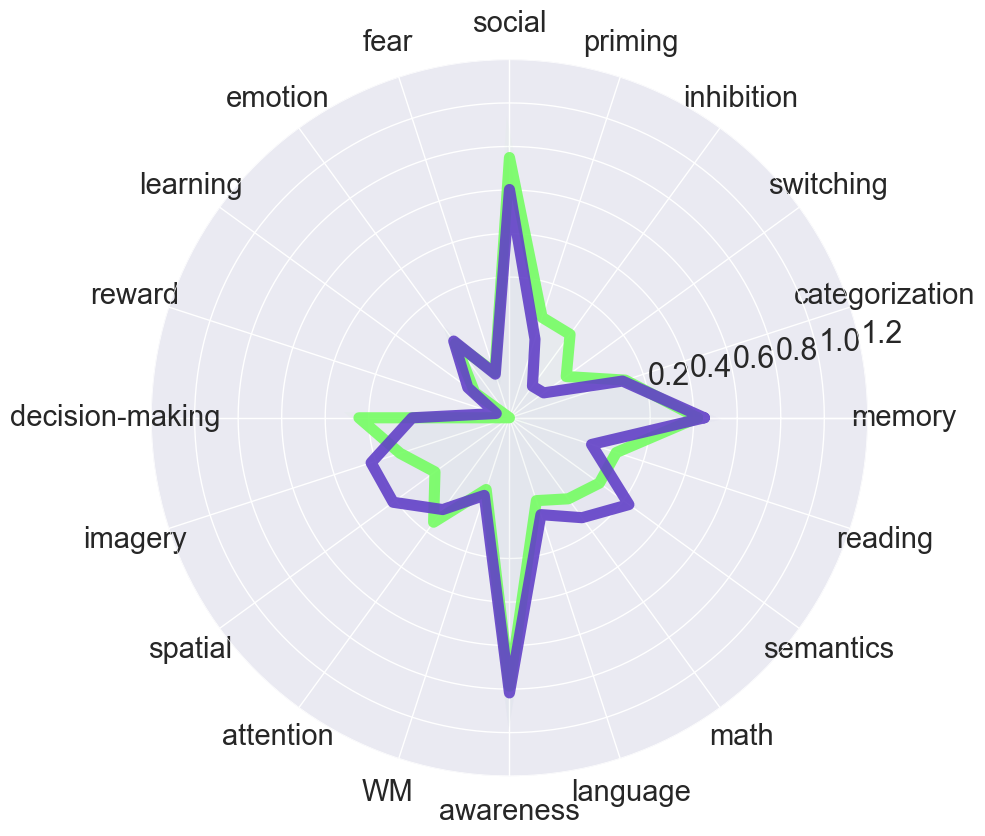

In [48]:
colors = ["lighter green","bluey purple"]
colors = sns.xkcd_palette(colors)
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)
_ = plot_clf_polar(formated_importances,labels = cognitive_topics, palette = colors, max_val=1.2,label_size=21)

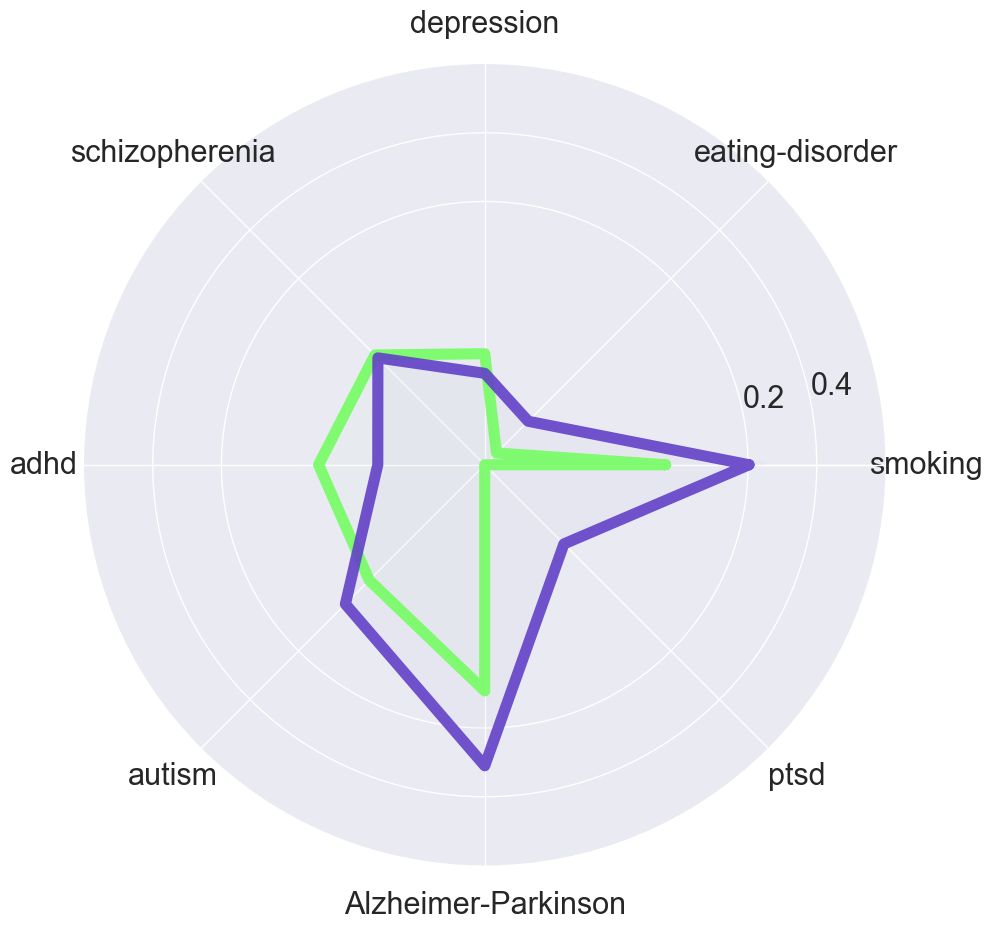

In [49]:
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)
_ = plot_clf_polar(formated_importances, labels = disease_topics, palette = colors,label_size=22,max_val=0.6)

In [47]:
# These are the names of each region given the manuscript
names_70 = ['dorsal','ventral']#['ventral','dorsal','lateral'] #rTPJ

In [48]:
from classification import permute_log_odds
lor_z = classification.permute_log_odds(clf, 1000, feature_names=nicknames.nickname, region_names = names_70)

[##########] 100%


In [49]:
lor_ci = classification.bootstrap_log_odds(clf, 1000, feature_names=nicknames.nickname, 
                                           region_names = names_70, n_jobs=7)
subset_plot = lor_ci[(lor_ci.topic_name.isin(cognitive_topics))]
import pandas as pd
df = pd.DataFrame(subset_plot)
df.to_csv('profiles/rTPJ_cog_ci.csv')

subset_plot = lor_ci[(lor_ci.topic_name.isin(disease_topics))]
df = pd.DataFrame(subset_plot)
df.to_csv('profiles/rTPJ_dis_ci.csv')

[##########] 100%


In [50]:
cog_ps = lor_z[lor_z.nickname.isin(cognitive_topics)]
from statsmodels.sandbox.stats.multicomp import multipletests

reject, p_corr, a, a1 = multipletests(cog_ps.p, alpha=0.01, method='fdr_tsbky')

cog_ps['p_corr_01'] = p_corr # Adjusted p-value
cog_ps['reject_01'] = (cog_ps.p_corr_01<0.05) & (cog_ps.lor_z > 0) # Was the null hypothesis rejected?

import pandas as pd
df = pd.DataFrame(cog_ps)
df.to_csv("profiles/rTPJ_cog.csv")


dis_ps = lor_z[lor_z.nickname.isin(disease_topics)]
from statsmodels.sandbox.stats.multicomp import multipletests

reject, p_corr, a, a1 = multipletests(dis_ps.p, alpha=0.01, method='fdr_tsbky')

dis_ps['p_corr_01'] = p_corr # Adjusted p-value
dis_ps['reject_01'] = (dis_ps.p_corr_01<0.05) & (dis_ps.lor_z > 0)
import pandas as pd
df = pd.DataFrame(dis_ps)
df.to_csv("profiles/rTPJ_dis.csv")

/Users/shaoming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaoming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaoming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

In [25]:
lor_ci = classification.bootstrap_log_odds(clf, 1000, feature_names=nicknames.nickname, 
                                           region_names = names_70, n_jobs=7)
subset_plot = lor_ci[(lor_ci.topic_name.isin(selected_topics))]

[##########] 100%


In [45]:
from matplotlib.colors import rgb2hex
from colors import l_70_colors
%load_ext rpy2.ipython

subset_plot = lor_ci[(lor_ci.topic_name.isin(cognitive_topics))]
colors_hex = [rgb2hex(c) for c in colors]
colors_hex, _ = zip(*sorted(zip(colors_hex, names_70), key=lambda tup: tup[1]))
colors_hex = list(colors_hex)

names = list(reversed(names_70))

s1 = ['reward','fear','emotion','memory','social','awareness','decision-making']
s2 = selected_topics[1:]

%Rpush subset_plot
%Rpush colors_hex
%Rpush names
%Rpush s2
%Rpush s1

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [94]:
rgb2hex(c)

u'#a8572c'

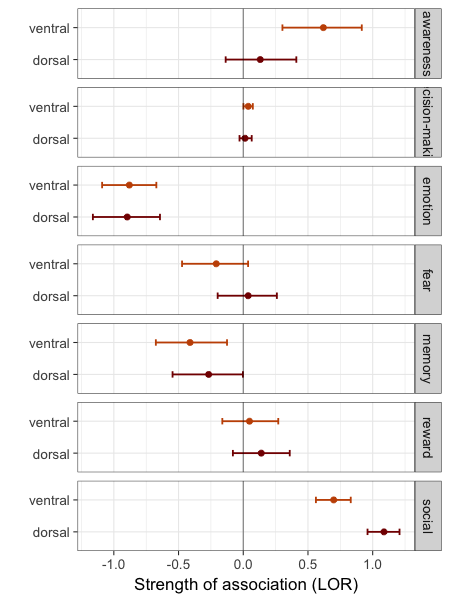

In [46]:
%%R -w 450 -h 600 
library(ggplot2)
ggplot(subset(subset_plot, topic_name %in% s1), aes(mean, region, color=factor(region))) + geom_point(size=2.5) + 
geom_errorbarh(aes(xmin=low_ci, xmax=hi_ci), height=.2, size=.85) + geom_vline(xintercept = 0, alpha=.5) + facet_grid(topic_name~.) +
theme_bw(base_size = 17) +  theme(legend.position="none") + labs(x = 'Strength of association (LOR)', y="") +
scale_color_manual(values = colors_hex) + scale_y_discrete(limits=names)